## Lab 6: Bayesian models (Solution)
We will first learn a GP regressor for an artificial, non-linear function to illustrate some basic aspects of GPs. To this end, we consider a sinusoidal function from which we sample a dataset. 

In [1]:
# General imports
%matplotlib inline
from preamble import *
plt.rcParams['figure.dpi'] = 100

The function to predict and the dataset we create from it:

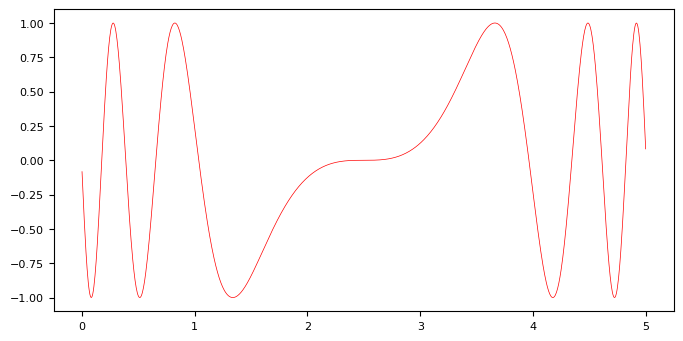

In [2]:
def f(x):
    """The function to predict."""
    return np.sin((x - 2.5) ** 3)

plt.figure(figsize=(8,4))
t = np.linspace(0,5,1000)
plt.plot(t, f(t), 'r', label = 'original f(x)')

The dataset we create based on the function:

In [3]:
# Dataset sampled from a sine function
rng = np.random.RandomState(4)
X_ = rng.uniform(0, 5, 1000)[:, np.newaxis]
y_ = f(X_).ravel()

In [4]:
def plot_gp(g, X_train, y_train, X_full, y_full, y_pred_mean, y_pred_std, use_title="yes"):
    """
    Visualizes the GP predictions, training points and original function
    
    Attributes:
    X_train -- The training data
    y_train -- The correct labels
    X_full -- The data to calculate predictions
    y_full -- The correct labels of the prediction data
    y_pred_mean -- the predicted means
    y_pred_std -- the predicted st. devs.
    """
    x_ = np.linspace(0, 5, 1000)[:,np.newaxis]
    
    idx = np.argsort(X_full[:,0])
    
    # Original function
    a = X_full[idx]
    b = y_full[idx]
    
    plt.figure(figsize=(8,4))
    plt.plot(a, 
             b, 'r', label = 'original f(x)')
    
    # Training points
    plt.scatter(X_train, y_train, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    
    # Prediction 
    d = y_pred_mean[idx]
    e = y_pred_std[idx]
    plt.plot(a, d, 'k', lw=1, zorder=9)
    plt.fill_between(a[:,0], d - 1.96*e, d + 1.96*e, alpha=0.2, color='k')
    
    if use_title == "yes":
        plt.title("Posterior (kernel: %s)\n Log-Likelihood: %.3f"
              % (g.kernel_, g.log_marginal_likelihood(g.kernel_.theta)),
              fontsize=12)
    plt.tight_layout()

## Exercise 1: visualizing predictions

Train a GP regressor with a RBF kernel with default hyperparameters on a 1% sample of the sine data. Note that by learning a GP the hyperparameters of the chosen kernel are tuned automatically. To visualize what the GP has learned, use the model to predict values for the entire dataset. Plot the original function, the predictions and the training data points. You can use the function `plot_gp()` to assist with plotting.

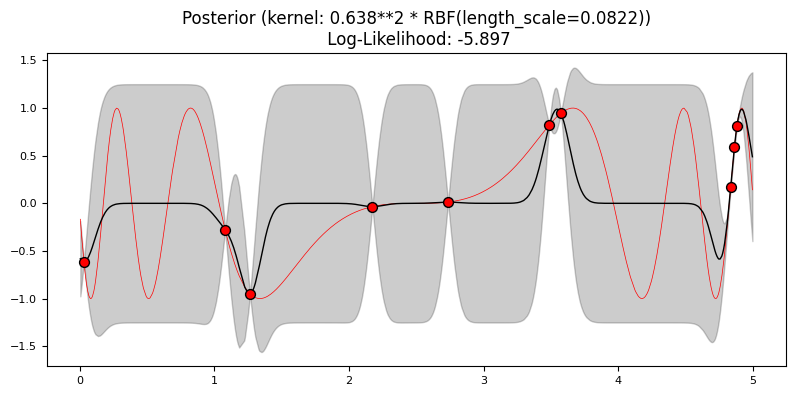

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)

X_train = X_[:10]
y_train = y_[:10]

kernel = 1.0 * RBF()
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

gp.fit(X_train, y_train)

y_pred_mean, y_pred_std = gp.predict(X_, return_std=True)

plot_gp(gp, X_train, y_train, X_, y_, y_pred_mean, y_pred_std)

## Exercise 2: reducing the uncertainty
Fit a model using 5% and 10% of the data. Now try setting `n_restarts_optimizer` in the `GaussianProcessRegressor` constructor. Plot the results. What differences do you see?

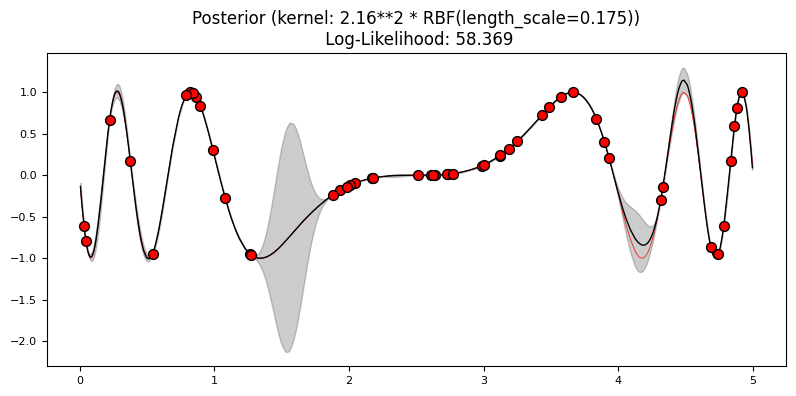

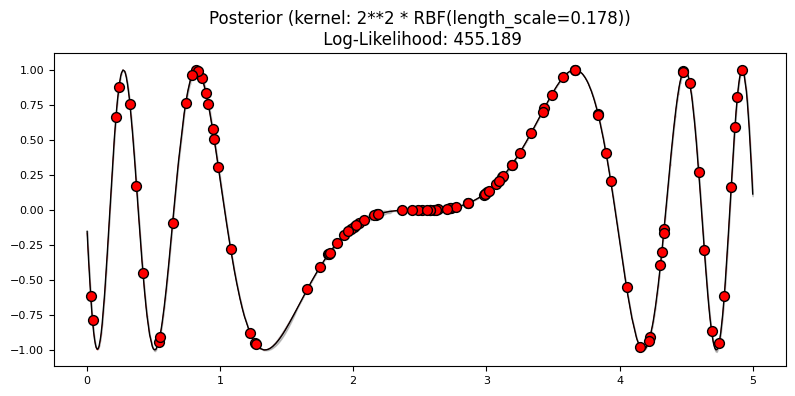

In [6]:
X2 = X_[:50]
y2 = y_[:50]

gp2 = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer=10)
gp2.fit(X2, y2)
y2_pred_mean, y2_pred_std = gp2.predict(X_, return_std=True)
plot_gp(gp2, X2, y2, X_, y_, y2_pred_mean, y2_pred_std)

X3 = X_[:100]
y3 = y_[:100]

gp3 = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer=10)

gp3.fit(X3, y3)
y3_pred_mean, y3_pred_std = gp3.predict(X_, return_std=True)
plot_gp(gp3, X3, y3, X_, y_, y3_pred_mean, y3_pred_std)


## Exercise 3: Kernels
Like SVMs, kernels play a major role in GPs. Using a 5% sample of the data, train one GP  with each of the following kernels:
    
* RBF
* RationalQuadratic
* ExpSineSquared
* DotProduct
* Matern

What differences do you see in the log-likelihood? Which model fit best the training data?

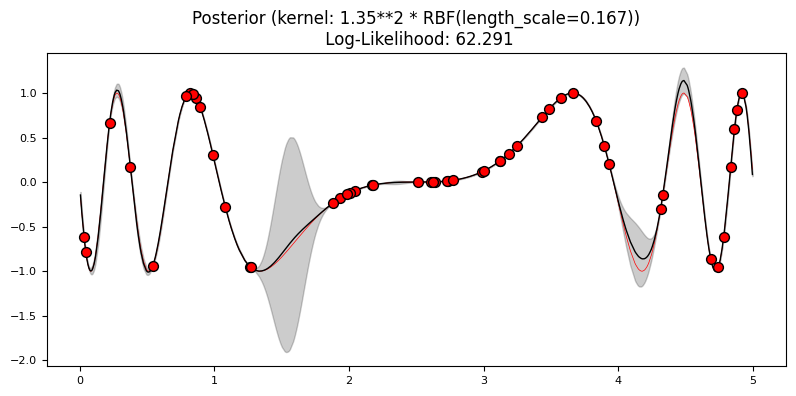

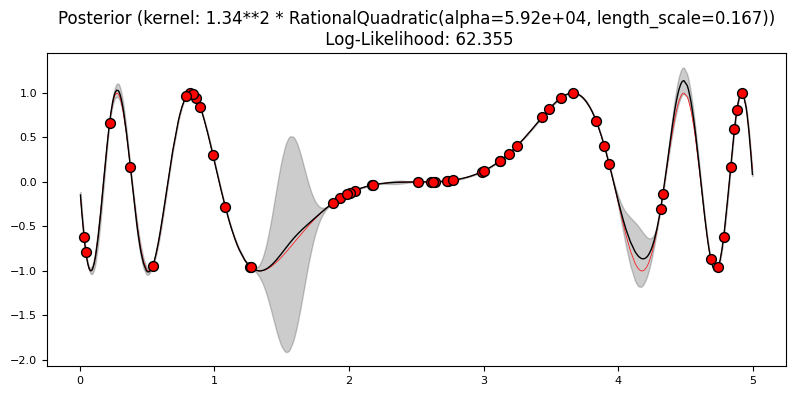

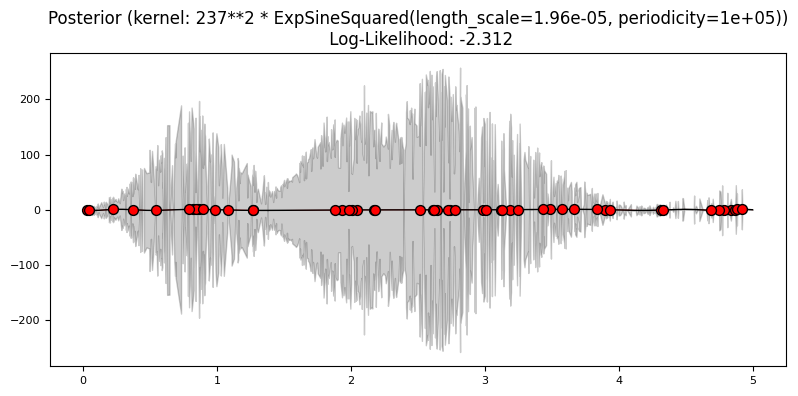

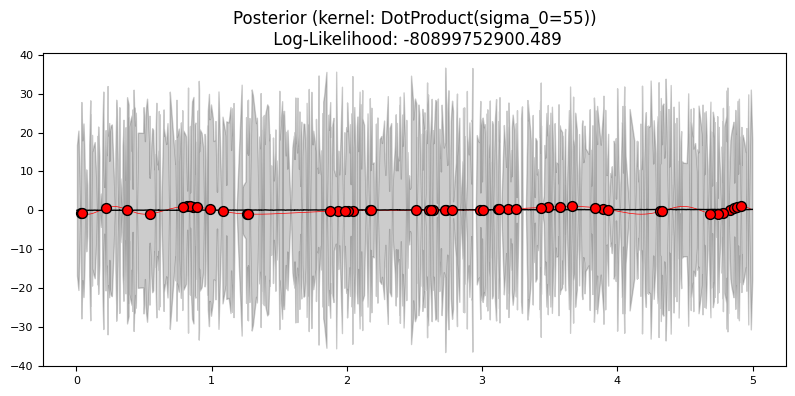

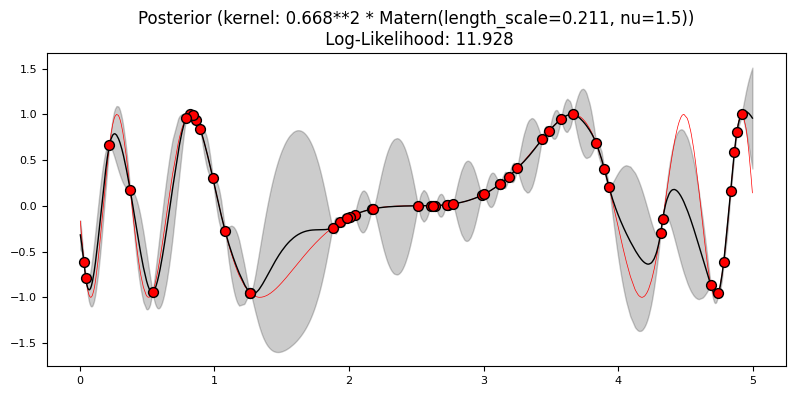

In [7]:
kernels = [1.0 * RBF(),
           1.0 * RationalQuadratic(),
           1.0 * ExpSineSquared(),
           DotProduct(),
           1.0 * Matern()]

for kernel in kernels:
    gp= GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10)
    gp.fit(X2, y2)
    y_pred_mean, y_pred_std = gp.predict(X_, return_std=True)
    plot_gp(gp, X2, y2, X_, y_, y_pred_mean, y_pred_std)

## Exercise 4: Mauna Loa data
We now look at the problem of predicting the monthly average CO2 concentrations collected at the Mauna Loa Observatory in Hawaii, between 1958 and 2001. This is a time-series data.

In [8]:
from sklearn.datasets import fetch_openml

# originally from sci-kit learn
def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187, as_frame=False)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1, 1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs


X_mauna, y_mauna = load_mauna_loa_atmospheric_co2()

Quick visualization:

Text(0, 0.5, 'co2')

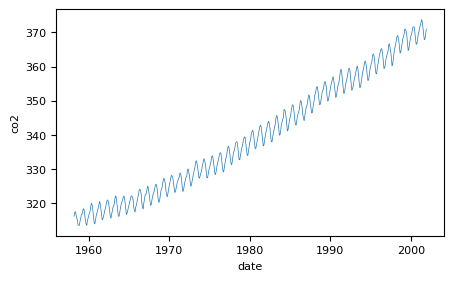

In [9]:
#Quick visualization
plt.plot(X_mauna,y_mauna)
plt.xlabel('date')
plt.ylabel('co2')

## Exercise 4.1
Signals like this usually consist of a combination of different "sub-signals", e.g. a long-term component, a seasonal component, a noise component, and so on. When defining a GP kernel, you can combine multiple kernels, such as:

* A RBF kernel can be used to explain long-term, smooth patterns.
* The seasonal component can be modeled by an `ExpSineSquared` component.
* Small and medium-term irregularities can be modeled by a `RationalQuadratic` component.
* `WhiteNoise` kernel to model white noise.

Train a GP using the first 75% data points as training data using the kernel below. Experiment with removing one or more kernels and check the results visually (you can use `plot_gp`). What do you observe?

In [10]:
from sklearn.gaussian_process.kernels import WhiteKernel

k1 = 50.0**2 * RBF(length_scale=50.0)  # long term smooth rising trend
k2 = 2.0**2 * RBF(length_scale=100.0) \
    * ExpSineSquared(length_scale=1.0, periodicity=1.0,
                     periodicity_bounds="fixed")  # seasonal component
# medium term irregularities
k3 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
k4 = 0.1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-5, np.inf))  # noise terms

kernel = k1 + k2 +  k3 + k4

Learned kernel: 
 50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)


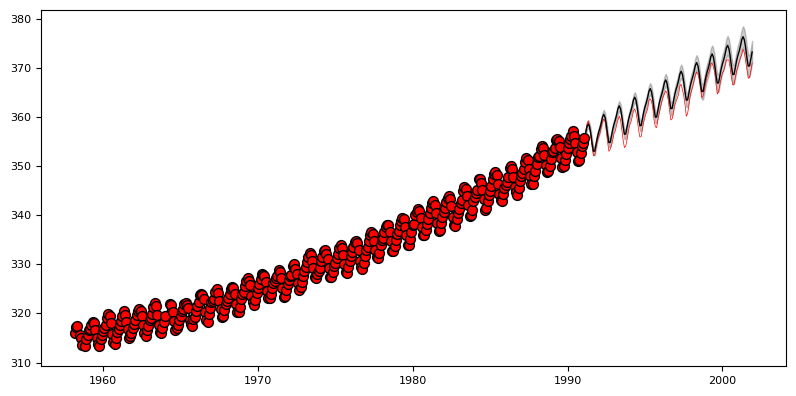

In [12]:
end = round(len(X_mauna) * 0.75)

gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gp.fit(X_mauna[:end], y_mauna[:end])

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_mean, y_sigma = gp.predict(X_mauna, return_std=True)

plot_gp(gp, X_mauna[:end], y_mauna[:end], X_mauna, y_mauna, y_mean, y_sigma, "no")

print("Learned kernel: \n",gp.kernel)